In [1]:
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [2]:
# notebooks/example_notebook.ipynb

import sys
import os
sys.path.append(os.path.abspath('../scripts'))

In [3]:
from load_data import load_data_from_postgres, load_data_using_sqlalchemy
from sql_queries import execute_telecom_queries

In [15]:
# Load environment variables from .env file
import os
from dotenv import load_dotenv
load_dotenv()

# Fetch database connection parameters from environment variables
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [5]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

c:\Users\hp\kifiya_10_acadamy\kifiya_week2_assignment\scripts\load_data.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [6]:


df['TCP Retransmission'] = df['TCP DL Retrans. Vol (Bytes)'] + df['TCP UL Retrans. Vol (Bytes)']
df['RTT'] = df['Avg RTT DL (ms)'] + df['Avg RTT UL (ms)'] 
df['Throughput'] = df['Avg Bearer TP DL (kbps)'] + df['Avg Bearer TP UL (kbps)']

# Step 1: Handle missing values
metrics = df[["TCP Retransmission", "RTT", "Throughput"]]
metrics.fillna(metrics.mean(), inplace=True)

# Step 2: Scale the metrics
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics)

# Step 3: Run k-means clustering (k = 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(metrics_scaled)

# Step 4: Identify the least engaged cluster (e.g., lowest average throughput)
cluster_centers = kmeans.cluster_centers_
cluster_profiles = pd.DataFrame(
    cluster_centers, columns=["TCP Retransmission", "RTT", "Throughput"]
)
least_engaged_cluster = cluster_profiles["Throughput"].idxmin()

# Step 5: Calculate Euclidean distance to the least engaged cluster center
least_engaged_center = cluster_centers[least_engaged_cluster]

# Compute engagement scores
engagement_scores = [
    np.sqrt(np.sum((row - least_engaged_center) ** 2)) for row in metrics_scaled
]
df["Engagement_Score"] = engagement_scores

# Output the results
print("User Engagement Scores:\n", df[["MSISDN/Number", "Cluster", "Engagement_Score"]])


C:\Users\hp\AppData\Local\Temp\ipykernel_22112\2233076192.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.fillna(metrics.mean(), inplace=True)


User Engagement Scores:
         MSISDN/Number  Cluster  Engagement_Score
0        3.366496e+10        0        121.058670
1        3.368185e+10        0        121.017729
2        3.376063e+10        0        120.916223
3        3.375034e+10        0        120.916223
4        3.369980e+10        0        120.916223
...               ...      ...               ...
149996   3.365069e+10        0        121.085371
149997   3.366345e+10        0        121.090711
149998   3.362189e+10        0        121.055110
149999   3.361962e+10        0        121.067570
150000            NaN        0        120.917510

[150001 rows x 3 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_22112\45395869.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x='Cluster', y='Engagement_Score', palette='viridis')


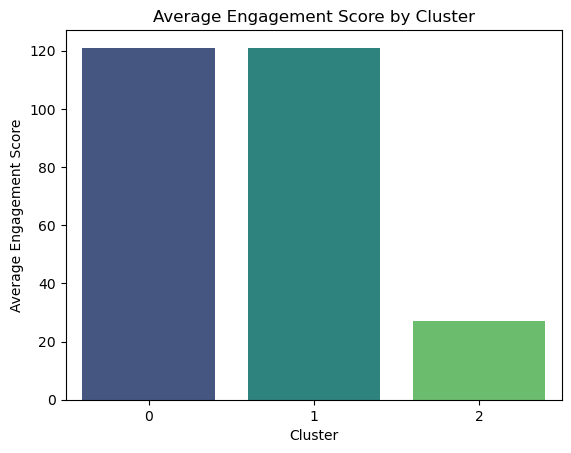

In [7]:
# Handling missing values (if any exist)
df = df.dropna(subset=['MSISDN/Number', 'Engagement_Score'])

# Group by 'Cluster' and calculate the mean Engagement Score
cluster_summary = df.groupby('Cluster')['Engagement_Score'].mean().reset_index()

# Plot the bar chart
sns.barplot(data=cluster_summary, x='Cluster', y='Engagement_Score', palette='viridis')
plt.title('Average Engagement Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Engagement Score')
plt.show()

In [8]:

# Step 1: Handle missing values
metrics = df[["TCP Retransmission", "RTT", "Throughput"]]
metrics.fillna(metrics.mean(), inplace=True)

# Step 2: Scale the metrics
scaler = StandardScaler()
metrics_scaled = scaler.fit_transform(metrics)

# Step 3: Run k-means clustering (k = 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(metrics_scaled)

# Step 4: Identify the "worst experience" cluster
cluster_centers = kmeans.cluster_centers_
cluster_profiles = pd.DataFrame(
    cluster_centers, columns=["TCP Retransmission", "RTT", "Throughput"]
)
worst_experience_cluster = cluster_profiles["TCP Retransmission"].idxmax()

# Step 5: Calculate Euclidean distance to the "worst experience" cluster center
worst_experience_center = cluster_centers[worst_experience_cluster]
experience_scores = [
    np.sqrt(np.sum((row - worst_experience_center) ** 2)) for row in metrics_scaled
]
df["Experience_Score"] = experience_scores

# Step 6: Compute Satisfaction Score as the average of Engagement and Experience scores
df["Satisfaction_Score"] = (df["Engagement_Score"] + df["Experience_Score"]) / 2

# Step 7: Identify top 10 satisfied customers
top_10_satisfied = df.nlargest(10, "Satisfaction_Score")

# Output the results
print("Top 10 Satisfied Customers:\n", top_10_satisfied[["MSISDN/Number", "Satisfaction_Score"]])


C:\Users\hp\AppData\Local\Temp\ipykernel_22112\789681319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.fillna(metrics.mean(), inplace=True)


Top 10 Satisfied Customers:
         MSISDN/Number  Satisfaction_Score
30166    3.366232e+10          116.167171
120890   3.366117e+10           73.398216
143670   3.367251e+10           72.771888
91313    3.366662e+10           72.610997
116807   3.365991e+10           72.488734
141458   3.366566e+10           72.447168
141262   3.369817e+10           72.446024
117791   3.376869e+10           72.407368
116565   3.366549e+10           72.402776
149617   3.365169e+10           72.376042


C:\Users\hp\AppData\Local\Temp\ipykernel_22112\24045912.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x='MSISDN/Number', y='Satisfaction_Score', palette='viridis')


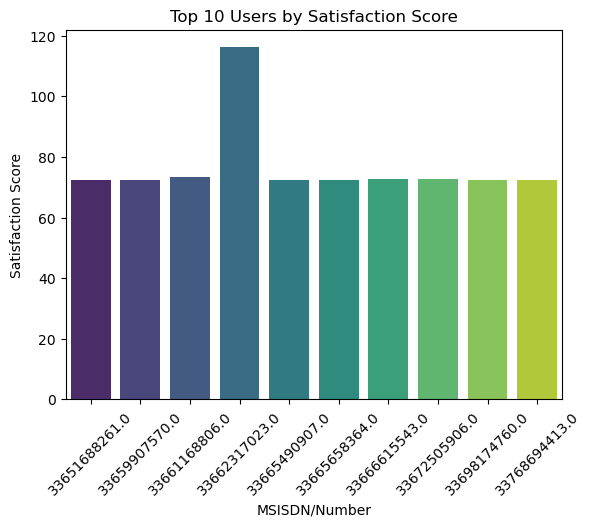

In [9]:
# Sort and take the top 10 users with highest satisfaction scores
top_users = df.sort_values(by='Satisfaction_Score', ascending=False).head(10)

# Bar Plot
sns.barplot(data=top_users, x='MSISDN/Number', y='Satisfaction_Score', palette='viridis')
plt.title('Top 10 Users by Satisfaction Score')
plt.xticks(rotation=45)
plt.xlabel('MSISDN/Number')
plt.ylabel('Satisfaction Score')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Calculate Satisfaction Score
df["Satisfaction_Score"] = (df["Engagement_Score"] + df["Experience_Score"]) / 2

# Step 2: Prepare features (X) and target (y)
X = df[["TCP Retransmission", "RTT", "Throughput", "Engagement_Score", "Experience_Score"]]
y = df["Satisfaction_Score"]

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a regression model (Random Forest Regressor)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:\n - MAE: {mae:.2f}\n - MSE: {mse:.2f}\n - R²: {r2:.2f}")

# Display feature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:\n", feature_importance)


Model Evaluation:
 - MAE: 0.00
 - MSE: 0.09
 - R²: 0.62

Feature Importance:
               Feature  Importance
4    Experience_Score    0.522695
1                 RTT    0.290811
0  TCP Retransmission    0.100942
3    Engagement_Score    0.085359
2          Throughput    0.000193


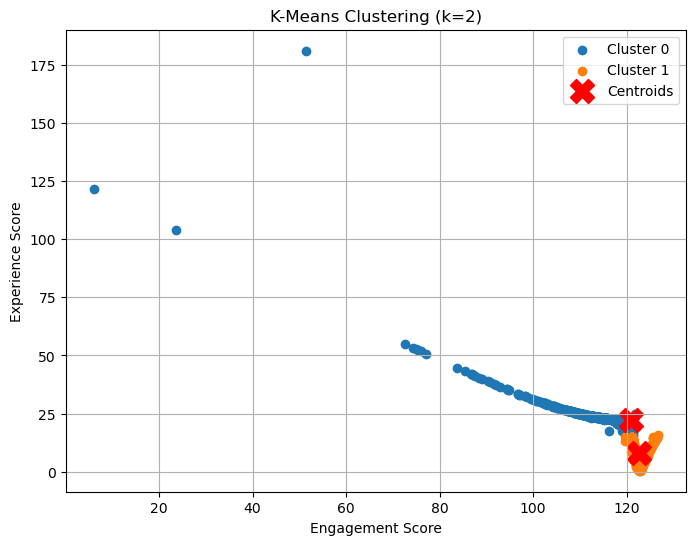

Cluster Assignments:
            Bearer Id            Start  Start ms              End  End ms  \
0       1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1       1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2       1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3       1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4       1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   
...              ...              ...       ...              ...     ...   
149995  1.304243e+19   4/29/2019 7:28     615.0   4/30/2019 0:01   407.0   
149996  7.277826e+18   4/29/2019 7:28     451.0   4/30/2019 6:02   214.0   
149997  7.349883e+18   4/29/2019 7:28     483.0  4/30/2019 10:41   187.0   
149998  1.311448e+19   4/29/2019 7:28     283.0  4/30/2019 10:46   810.0   
149999  1.311448e+19   4/29/2019 7:28     696.0  4/30/2019 10:40   327.0   

        Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0

In [11]:

# Step 1: Prepare data for clustering
clustering_data = df[["Engagement_Score", "Experience_Score"]]

# Step 2: Apply K-means clustering (k=2)
kmeans = KMeans(n_clusters=2, random_state=42)
df["Cluster"] = kmeans.fit_predict(clustering_data)

# Step 3: Visualize the clusters
plt.figure(figsize=(8, 6))
for cluster in df["Cluster"].unique():
    cluster_data = df[df["Cluster"] == cluster]
    plt.scatter(
        cluster_data["Engagement_Score"],
        cluster_data["Experience_Score"],
        label=f"Cluster {cluster}",
    )

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c="red", marker="X", label="Centroids")

# Add labels
plt.title("K-Means Clustering (k=2)")
plt.xlabel("Engagement Score")
plt.ylabel("Experience Score")
plt.legend()
plt.grid()
plt.show()

# Output cluster assignments
print("Cluster Assignments:\n", df)


In [12]:

# Step 1: Calculate the Satisfaction Score (average of Engagement and Experience Scores)
df["Satisfaction_Score"] = (df["Engagement_Score"] + df["Experience_Score"]) / 2

# Step 2: Prepare data for clustering
clustering_data = df[["Engagement_Score", "Experience_Score"]]

# Step 3: Apply K-means clustering (k=2)
kmeans = KMeans(n_clusters=2, random_state=42)
df["Cluster"] = kmeans.fit_predict(clustering_data)

# Step 4: Aggregate average satisfaction and experience score per cluster
cluster_avg_scores = df.groupby("Cluster")[["Satisfaction_Score", "Experience_Score"]].mean().reset_index()

# Output the aggregated results
print("Average Satisfaction & Experience Score per Cluster:\n", cluster_avg_scores)


Average Satisfaction & Experience Score per Cluster:
    Cluster  Satisfaction_Score  Experience_Score
0        0           71.524543         22.124143
1        1           65.440324          8.264773


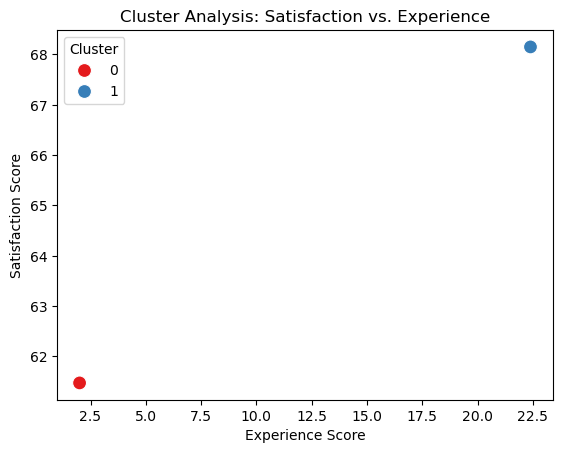

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (replace with your actual data)
cluster_data = {
    'Cluster': [0, 1],
    'Satisfaction_Score': [61.474667, 68.149946],
    'Experience_Score': [2.005900, 22.388833],
}
df_cluster = pd.DataFrame(cluster_data)

# Scatter plot
sns.scatterplot(data=df_cluster, x='Experience_Score', y='Satisfaction_Score', hue='Cluster', palette='Set1', s=100)
plt.title('Cluster Analysis: Satisfaction vs. Experience')
plt.xlabel('Experience Score')
plt.ylabel('Satisfaction Score')
plt.show()

In [55]:
import psycopg2

# PostgreSQL credentials
db_connection = psycopg2.connect(
    host="localhost",  # Replace with your PostgreSQL server's host
    user="postgres",   # Replace with your PostgreSQL username
    password="1240",   # Replace with your PostgreSQL password
    database="telecom_data",  # Replace with your PostgreSQL database name
    port=5432          # Default PostgreSQL port
)

cursor = db_connection.cursor()

# Test the connection
print("Connected to PostgreSQL Server!")

# Create a table
cursor.execute("""
CREATE TABLE IF NOT EXISTS user_data (
    Bearer_Id BIGINT PRIMARY KEY,
    Engagement_Score DOUBLE PRECISION,
    Experience_Score DOUBLE PRECISION,
    Satisfaction_Score DOUBLE PRECISION
);
""")

db_connection.commit()
cursor.close()
db_connection.close()

print("Table created successfully!")


Connected to PostgreSQL Server!
Table created successfully!


In [59]:
# Rename DataFrame columns to match the PostgreSQL table column names
df.rename(columns={
    "Bearer_Id": "msisdn_number", 
    "Engagement_Score": "engagement_score",
    "Experience_Score": "experience_score",
    "Satisfaction_Score": "satisfaction_score"
}, inplace=True)

# Check if the columns have been renamed successfully
print(df.columns)


Index(['msisdn_number', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)',
       'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name',
       'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)',
       'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)',
       'TCP UL Retrans. Vol (Bytes)', 'DL TP < 50 Kbps (%)',
       '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)',
       'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)',
       '10 Kbps < UL TP < 50 Kbps (%)', '50 Kbps < UL TP < 300 Kbps (%)',
       'UL TP > 300 Kbps (%)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)',
       'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1',
       'Handset Manufacturer', 'Handset Type',
       'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL 

In [62]:
import psycopg2

# PostgreSQL credentials
db_connection = psycopg2.connect(
    host="localhost",  # Replace with your PostgreSQL server's host
    user="postgres",   # Replace with your PostgreSQL username
    password="1240",   # Replace with your PostgreSQL password
    database="telecom_data",  # Replace with your PostgreSQL database name
    port=5432          # Default PostgreSQL port
)

cursor = db_connection.cursor()

# Insert data into the table
for _, row in df.iterrows():
    cursor.execute("""
        INSERT INTO user_data (msisdn_number, engagement_score, experience_score, satisfaction_score)
        VALUES (%s, %s, %s, %s)
        ON CONFLICT (msisdn_number) DO NOTHING;  -- Prevent duplicates on msisdn_number
    """, (row["msisdn_number"], row["engagement_score"], row["experience_score"], row["satisfaction_score"]))

db_connection.commit()
cursor.close()
db_connection.close()

print("Data inserted successfully!")


Data inserted successfully!
